In [1]:
import sys
sys.path.append('../')
import trimesh
import RawDataProcess.utils as util
import matplotlib.pyplot as plt
import cv2
import numpy as np
import joblib
np.set_printoptions(suppress=True)


In [12]:
def render_mutiview_single(root_dir, action, frame_idx, cam_params, cam_list, visualize=True):
    original_mesh = trimesh.load('%s/%s_em/pose%04i_em.ply' % (root_dir, action, frame_idx))
    render_imgs = {}
    for cam in cam_list:
        print(cam)
        # (fx, fy, cx, cy, h, w, k1, k2, ...)
        if 'kinect' in cam:
            intr = cam_params.get_intrinsic_param('%s_color' % cam)
        else:
            intr = cam_params.get_intrinsic_param('%s' % cam)
        # print(intr)
        # from azure kinect 0 depth to "cam" color
        extr = cam_params.get_extrinsic_transform('azure_kinect_0', cam, depth_cam=False)
        # print(extr.r, '\n', extr.t)

        if 'kinect' in cam:
            img = cv2.cvtColor(
                cv2.imread('%s/%s/%s/color/color%04i.jpg' % (root_dir, action, cam, frame_idx)), cv2.COLOR_BGR2RGB)
        elif 'event' in cam:
            img = cv2.imread('%s/%s/%s/full_pic/fullpic%04i.jpg' % (root_dir, action, cam, frame_idx))
        else:
            img1 = cv2.imread('%s/%s/%s_camera/polar0-45_%04i.jpg' % (root_dir, action, cam, frame_idx))
            img2 = cv2.imread('%s/%s/%s_camera/polar90-135_%04i.jpg' % (root_dir, action, cam, frame_idx))
            img = np.stack([img1[:, :, 0], img1[:, :, 1], img2[:, :, 0]], axis=2)

        verts = extr.transform(np.asarray(original_mesh.vertices))
        faces = original_mesh.faces
        # print(verts[0:10, :])

        dist = np.abs(np.mean(verts, axis=0)[2])
        render_img = (util.render_model(verts, faces, intr[5], intr[4], np.asarray(intr[0:4]), np.zeros([3]),
                                        np.zeros([3]), near=0.1, far=20+dist, img=img) * 255).astype(np.uint8)
        render_imgs[cam] = render_img
        if visualize:
            plt.figure(figsize=(8, 8))
            plt.imshow(render_img)
            plt.show()

    return render_imgs


dict_keys(['azure_kinect_0_color', 'azure_kinect_0_depth', 'azure_kinect_1_color', 'azure_kinect_1_depth', 'azure_kinect_2_color', 'azure_kinect_2_depth', 'kinect_v2_1_color', 'kinect_v2_1_depth', 'kinect_v2_2_color', 'kinect_v2_2_depth', 'event_camera', 'polar'])
dict_keys(['azure_kinect_0_d2c', 'azure_kinect_1_d2c', 'azure_kinect_2_d2c', 'kinect_v2_1_d2c', 'kinect_v2_2_d2c'])
dict_keys(['azure_kinect_2-kinect_v2_2', 'azure_kinect_0-azure_kinect_2', 'polar-azure_kinect_0', 'event_camera-azure_kinect_0', 'azure_kinect_0-azure_kinect_1', 'azure_kinect_1-kinect_v2_1'])
azure_kinect_0
azure_kinect_1
azure_kinect_2
kinect_v2_2


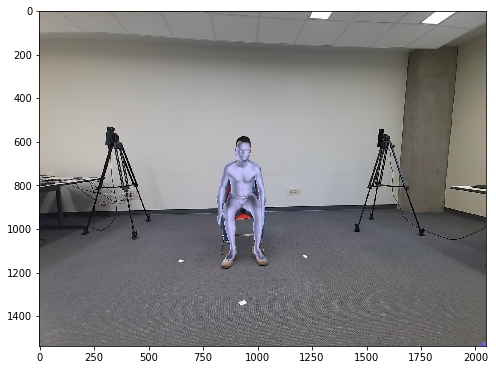

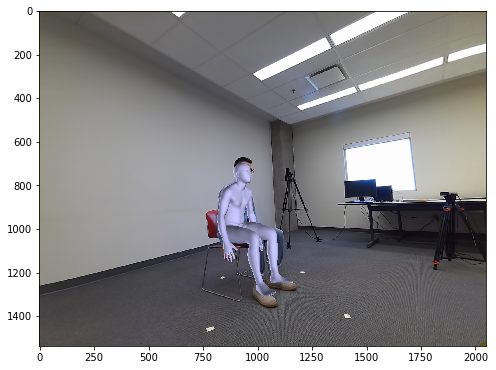

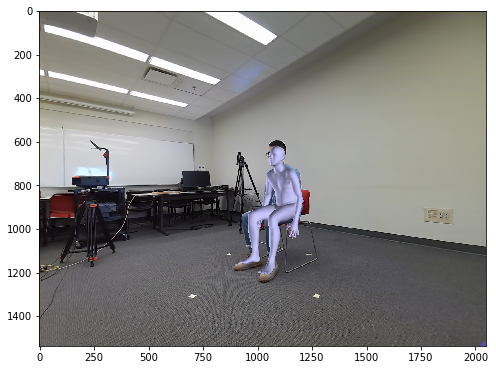

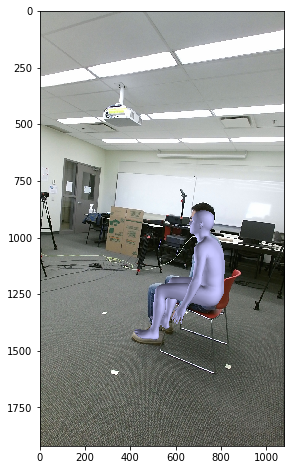

In [15]:
root_dir = '/home/shihao/data_10'
cam_params = util.MultiCamParams(root_dir)
action = '2'
frame_idx = 1
cam_list=('azure_kinect_0', 'azure_kinect_1', 'azure_kinect_2', 'kinect_v2_2')
# cam_list=('azure_kinect_0', 'azure_kinect_1', 'azure_kinect_2', 'kinect_v2_1', 'kinect_v2_2', 'event_camera', 'polar')
render_imgs = render_mutiview_single(root_dir, action, frame_idx, cam_params, cam_list, visualize=True)


In [3]:
root_dir = '/home/shihao/data_10'
cam_params = util.MultiCamParams(root_dir)
action = '1'
frame_idx = 100
cam = 'azure_kinect_0'
# cam_list=('azure_kinect_0', 'azure_kinect_1', 'azure_kinect_2', 'kinect_v2_1', 'kinect_v2_2')
intr = cam_params.get_intrinsic_param('%s_color' % cam)
extr = cam_params.get_extrinsic_transform('azure_kinect_0', 'azure_kinect_0', depth_cam=False)
print(intr, '\n', extr.r, '\n', extr.t)

dict_keys(['azure_kinect_0_color', 'azure_kinect_0_depth', 'azure_kinect_1_color', 'azure_kinect_1_depth', 'azure_kinect_2_color', 'azure_kinect_2_depth', 'kinect_v2_1_color', 'kinect_v2_1_depth', 'kinect_v2_2_color', 'kinect_v2_2_depth', 'event_camera', 'polar'])
dict_keys(['azure_kinect_0_d2c', 'azure_kinect_1_d2c', 'azure_kinect_2_d2c', 'kinect_v2_1_d2c', 'kinect_v2_2_d2c'])
dict_keys(['azure_kinect_2-kinect_v2_2', 'azure_kinect_0-azure_kinect_2', 'polar-azure_kinect_0', 'event_camera-azure_kinect_0', 'azure_kinect_0-azure_kinect_1', 'azure_kinect_1-kinect_v2_1'])
(976.7838346046938, 976.6954700661433, 1000.7015978283123, 784.6995695911885, 1536, 2048, 13.366022046162477, -11.15344330351859, 0.00016147564080253588, -0.008163149588165207, -88.58085389918612, 13.318338772065024, -12.813268592939618, -83.7145525534381) 
 [[ 0.99999886  0.00080678 -0.00127755]
 [-0.00067496  0.99498511  0.1000209 ]
 [ 0.00135184 -0.10001992  0.99498452]] 
 [-0.03220523 -0.0024212   0.00017579]


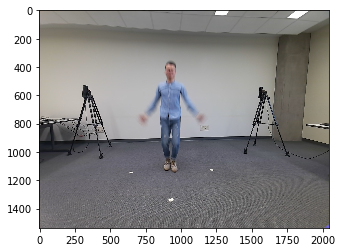

In [4]:
# read color image
color_img = cv2.cvtColor(
    cv2.imread('%s/%s/%s/color/color%04i.jpg' % (root_dir, action, cam, frame_idx)), cv2.COLOR_BGR2RGB)

plt.figure()
plt.imshow(color_img)
plt.show()

[[-0.30877208 -0.46885403  2.19465864]
 [-0.02502013 -0.57170689  2.16323581]
 [-0.11112357 -0.89294983  2.19054147]
 ...
 [-0.16682702 -0.89236616  2.16646673]
 [ 0.37948711 -0.10065161  2.28202793]
 [-0.24483367 -0.81763997  2.23276754]]
(1536, 2048, 4)
255 0


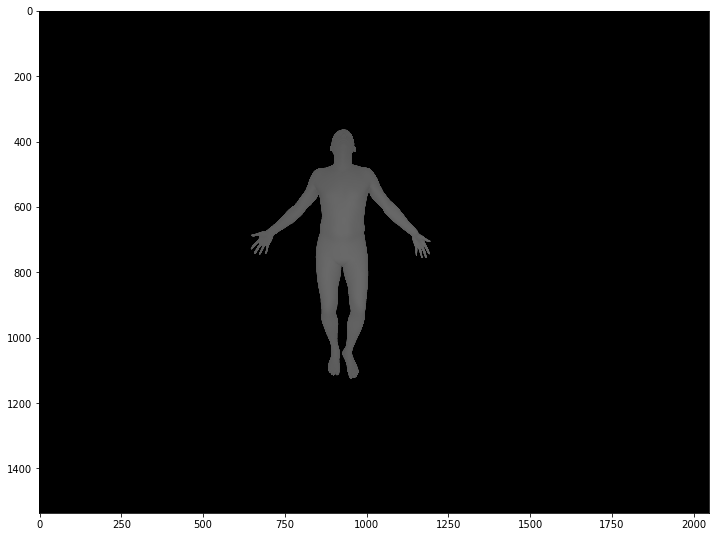

In [20]:
import os
os.environ["PYOPENGL_PLATFORM"] = "egl"
import pyrender

# read ply file
original_mesh = trimesh.load('%s/%s_em/pose%04i_em.ply' % (root_dir, action, frame_idx))

rot4 = cam_params.get_extrinsic_transform('azure_kinect_0', 'azure_kinect_0', depth_cam=False).getmat4()
original_mesh.apply_transform(rot4)
# original_mesh.vertices[:, 2] = - original_mesh.vertices[:, 2]
print(original_mesh.vertices)

mesh = pyrender.Mesh.from_trimesh(original_mesh)
scene = pyrender.Scene(bg_color=[0, 0, 0, 0], ambient_light=(0.3, 0.3, 0.3))
# scene = pyrender.Scene()
scene.add(mesh, 'mesh')

# add camera pose
camera_pose = np.array([[1, 0, 0, 0],
                        [0, -1, 0, 0],
                        [0, 0, -1, 0],
                        [0, 0, 0, 1]])
# use this to make it to center
camera = pyrender.camera.IntrinsicsCamera(fx=intr[0], fy=intr[1], cx=intr[2], cy=intr[3])
scene.add(camera, pose=camera_pose)

# Get the lights from the viewer
light = pyrender.SpotLight(color=np.ones(3), intensity=3.0, innerConeAngle=np.pi/16.0, outerConeAngle=np.pi/6.0)
scene.add(light, pose=camera_pose)

# offscreen render
r = pyrender.OffscreenRenderer(viewport_width=intr[5], viewport_height=intr[4])
color, depth = r.render(scene, flags=pyrender.RenderFlags.RGBA)
r.delete()

print(color.shape)
print(color.max(), color.min())

plt.figure(figsize=(8, 8))
plt.imshow(color[:, :, 0:3])
plt.show()


In [11]:
'''
import torch
from RawDataProcess.SMPL import SMPL
model_dir = '/home/shihao/MultiCameraDataProcessing/fitting/models'
model_male_path = '%s/basicModel_m_lbs_10_207_0_v1.0.0.pkl' % model_dir
model_female_path = '%s/basicModel_f_lbs_10_207_0_v1.0.0.pkl' % model_dir

device = torch.device('cpu')
smpl = SMPL(model_male_path, 16, obj_saveable=True).to(device)

beta = torch.tensor(tmp['shape']).float().to(device)
theta = torch.tensor(tmp['pose']).float().to(device)
verts, joint, _ = smpl(beta, theta, get_skin=True)
verts = verts[0].cpu().numpy() + cam_t
print(verts)
'''

[[-0.07996304 -1.1465609   2.1084013 ]
 [-0.08330759 -1.1384723   2.0940964 ]
 [-0.07341148 -1.1309941   2.1015007 ]
 ...
 [-0.20726761 -1.0556006   2.155418  ]
 [-0.20758289 -1.0578427   2.1545293 ]
 [-0.20991704 -1.0567715   2.1505744 ]]


[[-0.30877208 -0.46885403  2.19465864]
 [-0.02502013 -0.57170689  2.16323581]
 [-0.11112357 -0.89294983  2.19054147]
 ...
 [-0.16682702 -0.89236616  2.16646673]
 [ 0.37948711 -0.10065161  2.28202793]
 [-0.24483367 -0.81763997  2.23276754]]


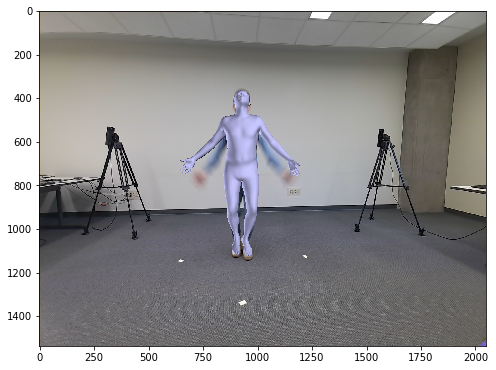

In [5]:
original_mesh = trimesh.load('%s/%s_em/pose%04i_em.ply' % (root_dir, action, frame_idx))
verts = extr.transform(np.asarray(original_mesh.vertices))
faces = original_mesh.faces
print(verts)

# tmp = joblib.load('%s/%s_em/pose%04i_em.pkl' % (root_dir, action, frame_idx))
# cam_t = tmp['trans']
# print(tmp)

cam_param = np.asarray(intr[0:4])
dist = np.abs(np.mean(verts, axis=0)[2])
render_img = util.render_model(verts, faces, intr[5], intr[4], cam_param, np.zeros([3]), np.zeros([3]),
                               near=0.5, far=20+dist, img=color_img)

plt.figure(figsize=(8, 8))
plt.imshow(render_img)
plt.show()